# 2 Kernelized SVM vs Neural Networks: Theory and Empirics

Comparing Empirical Performance of KSVMs and NNs: If both KSVMs and NNs have universal approximation (as seen in previous parts), then why are NNs more used in practice?

While both KSVMs and NNs are powerful models that can work well on arbitrarily complex datasets, on simpler datasets, we want models that require fewer training samples to yield good prediction. Here we will compare the relative performance of KSVMs and NNs on increasingly complex datasets and study which model class adapts better.

Download the dataset provided. It contains train and test samples of various sizes of (x, y) pairs of functions with increasing complexity. For this question, you may use any library you want.


### (i) To get a feel for the data, create scatter plots (x vs. y) using 50 training samples and 1000 training samples for each function complexity. (There are a total of 10 plots.)

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
from sklearn.metrics import mean_squared_error
import torch
import tqdm
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import copy


In [5]:
#root = '/Users/charlottewang/Documents/GitHub/Machine-Learning/hw/hw4/ksvm_nn_data'
!unzip ksvm_nn_data.zip
root='/content/ksvm_nn_data'
folder = os.listdir(root)
file_paths=[]
train=[[]]*5
test=[[]]*5
for f in folder:
    if f.startswith('complexity'):
        file_paths.append(root+'/'+f)
for p in file_paths:
    files = os.listdir(p)
    for f in files:
        if f.endswith('train.csv'):
            #globals()['train_%s' % p[-1]] = pd.read_csv(p+'/'+f)
            train[int(p[-1])] = pd.read_csv(p+'/'+f)
        elif f.endswith('test.csv'):
            #globals()['test_%s' % p[-1]] = pd.read_csv(p+'/'+f)
            test[int(p[-1])] = pd.read_csv(p+'/'+f)


Archive:  ksvm_nn_data.zip
   creating: ksvm_nn_data/
  inflating: __MACOSX/._ksvm_nn_data  
  inflating: ksvm_nn_data/.DS_Store  
  inflating: __MACOSX/ksvm_nn_data/._.DS_Store  
   creating: ksvm_nn_data/complexity1/
  inflating: __MACOSX/ksvm_nn_data/._complexity1  
   creating: ksvm_nn_data/complexity0/
  inflating: __MACOSX/ksvm_nn_data/._complexity0  
   creating: ksvm_nn_data/complexity2/
  inflating: __MACOSX/ksvm_nn_data/._complexity2  
   creating: ksvm_nn_data/complexity3/
  inflating: __MACOSX/ksvm_nn_data/._complexity3  
   creating: ksvm_nn_data/complexity4/
  inflating: __MACOSX/ksvm_nn_data/._complexity4  
  inflating: ksvm_nn_data/complexity1/test.csv  
  inflating: __MACOSX/ksvm_nn_data/complexity1/._test.csv  
  inflating: ksvm_nn_data/complexity1/train.csv  
  inflating: __MACOSX/ksvm_nn_data/complexity1/._train.csv  
  inflating: ksvm_nn_data/complexity0/test.csv  
  inflating: __MACOSX/ksvm_nn_data/complexity0/._test.csv  
  inflating: ksvm_nn_data/complexity0/tra

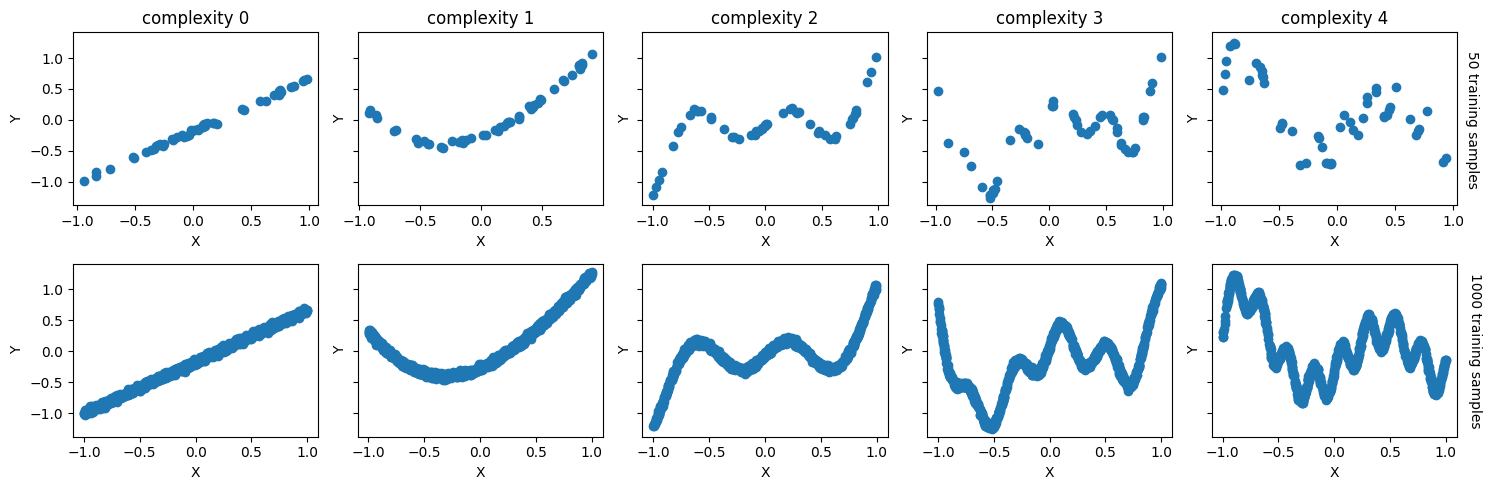

In [6]:
collections = ['Complexity 0', 'Complexity 1', 'Complexity 2', 'Complexity 3','Complexity 4']
fig, axes = plt.subplots(2, 5, figsize=(15, 5), sharey=True)

for i in range(5):
    axes[0,i].scatter(train[i]['x'][:50], train[i]['y'][:50])
    axes[0,i].set_xlabel('X')
    axes[0,i].set_ylabel('Y')
    axes[0,i].set_title(f'complexity {i}')
    if i == 4:
        axes[0,i].text(1.1,0,'50 training samples',verticalalignment='center',rotation=270) 
for i in range(5):
    axes[1,i].scatter(train[i]['x'][:1000], train[i]['y'][:1000])
    axes[1,i].set_xlabel('X')
    axes[1,i].set_ylabel('Y')
    if i == 4:
        axes[1,i].text(1.2,0,'1000 training samples',verticalalignment='center',rotation=270) 
plt.tight_layout()
plt.show()

(j) Train an RBF KSVM regressor and a NN for each function complexity with varying number of training samples.
Suggestions: 

For the SVM, it is advised you use SciKitLearn’s the built in Support Vector Regression function. The default settings should work fine, just ensure that you specify the right kernel. 

For the NN, it is advised you use PyTorch. Using a small neural network with 2 or 3 hidden layers and a dozen or a few dozen neurons per layer with the Adam optimizer and ReLU activation function should work well. To squeeze out good performance, try changing the number of epochs and the batch size first. Additionally, see this reference for more training tips: http://karpathy.github.io/2019/04/25/recipe/. You must use the MSE loss. 

For training sample sizes, consider sizes 50, 100, 300, 500, 750, and 1000.

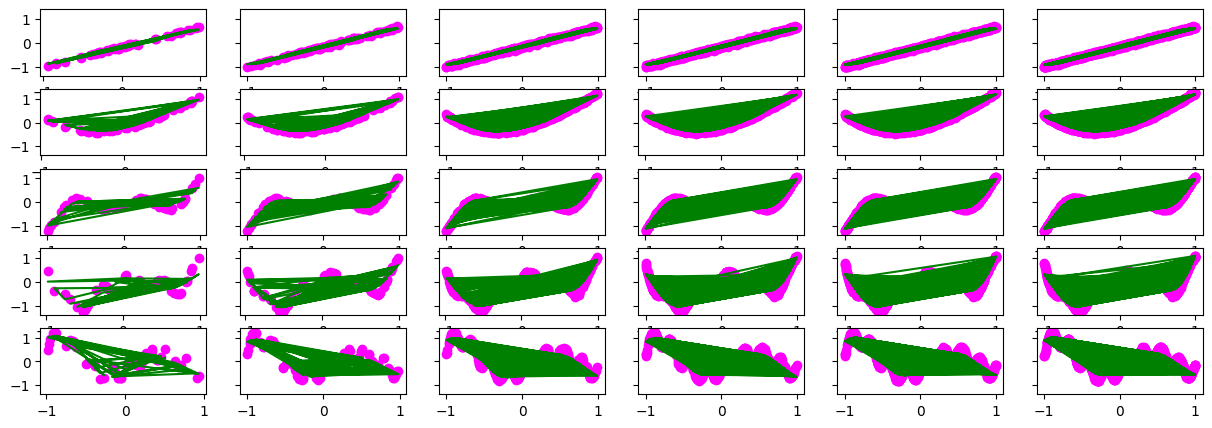

In [8]:
#RBF KSVM
svr = svm.SVR(kernel='rbf')
sample_size = [50, 100, 300, 500, 750, 1000]
mse_svm = np.zeros(shape=(5, len(sample_size)))
fig, axes = plt.subplots(5, 6, figsize=(15, 5), sharey=True)
for i in range(5):
    for b in range(len(sample_size)):
        train_x = np.array(train[i]['x']).reshape(-1,1)[:sample_size[b]]
        train_y = np.array(train[i]['y'])[:sample_size[b]]
        test_x = np.array(test[i]['x']).reshape(-1,1)
        test_y = np.array(test[i]['y'])
        svr.fit(train_x, train_y)
        pred_y = svr.predict(test_x)
        mse_svm[i][b]= mean_squared_error(test_y,pred_y)

        axes[i,b].scatter(train_x, train_y, color = 'magenta')
        axes[i,b].plot(train_x, svr.predict(train_x), color = 'green')
plt.show()

In [82]:
# Neural Network complexity 0 < 0.004568220033901941 (50)
train_x = np.array(train[0]['x'])
train_y = np.array(train[0]['y'])
test_x = np.array(test[0]['x'])
test_y = np.array(test[0]['y'])

train_x0 = torch.tensor(train_x,dtype=torch.float32).reshape(-1,1)
train_y0 = torch.tensor(train_y,dtype=torch.float32)
test_x0 = torch.tensor(test_x,dtype=torch.float32).reshape(-1,1)
test_y0 = torch.tensor(test_y,dtype=torch.float32)

In [78]:
model = nn.Sequential(
    nn.Linear(1,1),
    nn.ReLU(),
    nn.Linear(1,1),
    nn.ReLU(),
    nn.Linear(1,1)
)


loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.1)

<ipython-input-34-da4c436ae150>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(x_torch_test_0.float(), torch.tensor(y_pred_test.float()), color = 'green')
<ipython-input-34-da4c436ae150>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(x_torch_test_0.float(), torch.tensor(y_pred_test.float()), color = 'blue')


tensor(0.0006, grad_fn=<MseLossBackward0>)


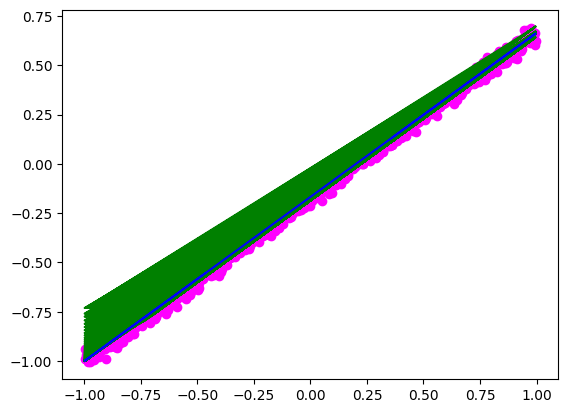

In [34]:
#complexity 0 
model = nn.Sequential(
    nn.Linear(1,1),
    nn.ReLU(),
    nn.Linear(1,1)
)
x_torch_train_0 = torch.from_numpy(np.array(train[0]['x'])).reshape(-1,1)
y_torch_train_0 = torch.from_numpy(np.array(train[0]['y'])).reshape(-1,1)
x_torch_test_0 = torch.from_numpy(np.array(test[0]['x'])).reshape(-1,1)
y_torch_test_0 = torch.from_numpy(np.array(test[0]['y'])).reshape(-1,1)

loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.01)


n_epochs = 100   # number of epochs to run
batch_size = 32  # size of each batch

best_mse = np.inf   # init to infinity
best_weights = None
history = []
plt.scatter(x_torch_test_0, y_torch_test_0, color = 'magenta')

# training loop
for epoch in range(n_epochs):
    for batch in range(batch_size):
        start = batch * batch_size
        end = start + batch_size
        batch_X = x_torch_train_0[start:end]
        batch_y = y_torch_train_0[start:end]
        # forward pass
        y_pred = model(batch_X.float())
        loss = loss_fn(y_pred.float(), batch_y.float())
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
    # evaluate accuracy at end of each epoch
    y_pred_test = model(x_torch_test_0.float())
    y_pred_test.reshape(-1,1)
    mse = loss_fn(y_pred_test.float(),y_torch_test_0.float())
    if epoch == n_epochs-1:
      plt.plot(x_torch_test_0.float(), torch.tensor(y_pred_test.float()), color = 'blue')
    else:
      plt.plot(x_torch_test_0.float(), torch.tensor(y_pred_test.float()), color = 'green')
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        #print(best_mse)
        best_weights = copy.deepcopy(model.state_dict())
print(best_mse)
# restore model and return best accuracy
model.load_state_dict(best_weights)
plt.show()

In [99]:
np.shape(np.array(train[0]['y']).reshape(-1,1))

(1000, 1)

<ipython-input-16-5d88bfa06796>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(x_torch_train_0.float(), torch.tensor(pred.float()), color = 'green')


epoch 1, loss 1.1339744329452515
epoch 2, loss 1.1099661588668823
epoch 3, loss 1.0862218141555786
epoch 4, loss 1.0627458095550537
epoch 5, loss 1.039542555809021
epoch 6, loss 1.0166162252426147
epoch 7, loss 0.9939706325531006
epoch 8, loss 0.9716094732284546
epoch 9, loss 0.9495364427566528
epoch 10, loss 0.9277546405792236
epoch 11, loss 0.9062673449516296
epoch 12, loss 0.8850772976875305
epoch 13, loss 0.8641873002052307
epoch 14, loss 0.8435996174812317
epoch 15, loss 0.8233163952827454
epoch 16, loss 0.8033396005630493
epoch 17, loss 0.7836708426475525
epoch 18, loss 0.764311671257019
epoch 19, loss 0.7452631592750549
epoch 20, loss 0.7265262007713318
epoch 21, loss 0.7081015110015869
epoch 22, loss 0.6899895071983337
epoch 23, loss 0.6721903681755066
epoch 24, loss 0.6547040343284607
epoch 25, loss 0.6375303268432617
epoch 26, loss 0.6206687092781067
epoch 27, loss 0.604118287563324
epoch 28, loss 0.5878784656524658
epoch 29, loss 0.5719478726387024
epoch 30, loss 0.556325256

<ipython-input-16-5d88bfa06796>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(x_torch_train_0.float(), torch.tensor(pred.float()), color = 'blue')


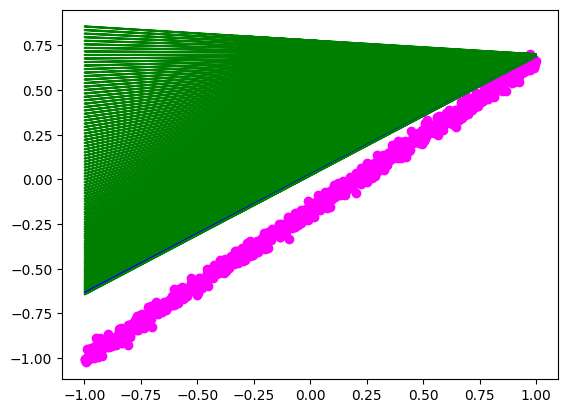

In [16]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.linear=nn.Linear(1, 1)
        
    def forward(self, x):
        out=self.linear(x)
        return out
model = LinearRegressionModel(1, 1)
loss_fn=nn.MSELoss()
optimizer=optim.Adam(model.parameters(), lr=0.01)
epochs=100
x_torch_train_0 = torch.from_numpy(np.array(train[0]['x']).reshape(-1,1))
y_torch_train_0 = torch.from_numpy(np.array(train[0]['y']).reshape(-1,1))
x_torch_test_0 = torch.from_numpy(np.array(test[0]['x']).reshape(-1,1))
y_torch_test_0 = torch.from_numpy(np.array(test[0]['y']).reshape(-1,1))
plt.scatter(x_torch_train_0, y_torch_train_0, color = 'magenta')
for epoch in range(epochs):
    epoch+=1

    #clear gradients wrt parameters
    optimizer.zero_grad()
    
    #Forward to get outputs
    pred=model(x_torch_train_0.float())
    
    #calculate loss
    loss=loss_fn(pred.float(), y_torch_train_0.float())
    if epoch == epochs-1:
      plt.plot(x_torch_train_0.float(), torch.tensor(pred.float()), color = 'blue')
    else:
      plt.plot(x_torch_train_0.float(), torch.tensor(pred.float()), color = 'green')
    
    #getting gradients wrt parameters
    loss.backward()
    
    #updating parameters
    optimizer.step()
    
    print('epoch {}, loss {}'.format(epoch, loss.data))
plt.show()

### (k) For both KSVM and NN predictors, and each function complexity, plot the test MSE error for varying training sizes.

In [7]:
mse_svm[0][0]

0.004568220033901941

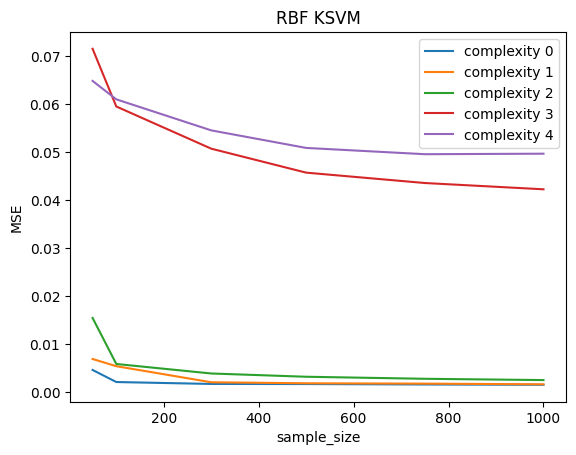

In [9]:
for i in range(5):
    plt.plot(batch, mse_svm[i],label=f'complexity {i}')
plt.xlabel('sample_size')
plt.ylabel('MSE')
plt.title('RBF KSVM')
plt.legend()
plt.show()
    

In [ ]:
from sklearn.datasets import fetch_california_housing
 
data = fetch_california_housing()
print(data.feature_names)
 
X, y = data.data, data.target
type(X)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


numpy.ndarray